# Crystal Electric Field (CF) Analysis of the Pr4+ ion
Here the goal is to use collected inelastic neutron scattering (INS) data to determine the ground state crystal field Hamiltonian. The Stevens' coefficients first guess comes from the grid search. I use PyCrystalField in conjunction with LMFIT to find the true values of the Stevens' Coefficients by fitting predicted energy levels to measured one. I then calculate the CF Hamiltonian and predict the compounds thermodynamic properties. Magnetization (M vs H) and Susceptibility (M vs T) data. 

It's important to note that I don't actually use Pr4+ as my central ion, I use Ce3+. The correct orbital values for the Ln4+ oxidized states have not been calculated and tabulated. Since the operators depend on electronic orbital states, I can use an electrically equivalent ion, Ce3+, instead of the actual Pr4+ ion.

In [135]:
import sys
sys.path.append('..')
from JensenTools import *
import seaborn as sns
sns.set()

##  Energy function to be made into LMFIT model

In [136]:
#####################################################################################################################################################################
# Simple function for pritting my parameters after fitting so that I can copy paste the values from output for further iterations.
def paramPrint(fittedparams):
	print()
	for i in fittedparams:
		# print(i, ' = ', i.value)
		print(i, ' = ',fittedparams[i].value )

# Function to be made into an LMFIT model.
def energyFit(B40,B60, B44, B64, B20, numlevels, LS, **kwargs ):
	numlevels = numlevels
	Stev = {} #Creating the Stevens' Coefficients dictionary and assigning values
	Stev['B20'] = B20
	Stev['B40'] = B40
	Stev['B60'] = B60
	Stev['B44'] = B44
	Stev['B64'] = B64

	if kwargs['LS_on']:
		Pr = cef.LS_CFLevels.Bdict(Bdict=Stev, L=3, S=0.5, SpinOrbitCoupling = LS) #Create CF_Levels obejct wtih the given coefficients.
		Pr.diagonalize()
		if kwargs['Kmeans']:
			e = kmeansSort(Pr.eigenvalues,numlevels)[:numlevels-1] #Excluding the highest mode which we did not detect in our INS runs
			# e.append(e[2]/e[1]) #The aforementioned ratio
		else: 
			e = Pr.eigenvalues
	else:
		Pr = cef.CFLevels.Bdict(Bdict = Stev, ion = kwargs['ion'])
		Pr.diagonalize()
		if kwargs['Kmeans']:   	
			e = kmeansSort(Pr.eigenvalues,numlevels)[:numlevels-1] #Excluding the highest mode which we did not detect in our INS runs
			e.append(e[1]/e[0]) #The aforementioned ratio
		else:
			e =  Pr.eigenvalues
	return e

# Function to be made into an LMFIT model.
def magFit(Pr,a,b,c, HTes, **kwargs ):
    mag = []
    if kwargs['LS_on']:
        for i in HTes:
            mag.append(a*Pr.magnetization(Temp = Temp, Field = [i, 0, 0])[0] + b*Pr.magnetization(Temp = Temp, Field = [0, i, 0])[1] + c*Pr.magnetization(Temp = Temp, Field = [0, 0, i])[2])
    else:
        for i in HTes:
            mag.append(a*Pr.magnetization(Temp = Temp, Field = [i, 0, 0], ion = ion)[0] + b*Pr.magnetization(Temp = Temp, Field = [0, i, 0], ion = ion)[1] + c*Pr.magnetization(Temp = Temp, Field = [0, 0, i], ion = ion)[2])
    return -1*np.array(mag)
#####################################################################################################################################################################

## Define kwargs and other important things

In [137]:
# Define important things
#####################################################################################################################################################################
comp = 'Sr2PrO4'
ion = 'Ce3+'
who = 'Arun'
LS_on = True
Kmeans = True
molweight = molweight[comp]
LSValue = 100

if LS_on:
	numlevels = 4
	Emeas = [168, 335,385] # The measured INS magnetic modes
else:
	numlevels = 3
	Emeas = [168, 335, 335/168] # The measured INS magnetic modes, only first 2 for J basis
    
# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
#####################################################################################################################################################################

## Load the project's data directories from my DropBox

In [138]:
saveDir = getSaveDir('m',comp = comp)
MHDir = getSaveDir('m',comp = comp, dataType = 'MH')
MTDir = getSaveDir('m',comp = comp, dataType = 'MT')

## Starting values from grid search for both LS and J basis

In [139]:
# From GridSearch For LS
#####################################################################################################################################################################
if LS_on:
	LS = LSValue
	x =  0.03629536921151444
	bpf = -0.6570713391739674
	# Assigning the coefficients from grid search
	# Enforcing cubic constraints as a start
	# and including the B20 term which is needed for tetragonal symmetry
	B40 = bpf
	B60 = x*bpf
	B44 = 5*B40
	B64 = -21*B60
	B20 = 0
#####################################################################################################################################################################

# From GridSearch For J
#####################################################################################################################################################################
if not LS_on:
	x = -1.0000
	bpf = -0.4673
	# Assigning the coefficients from grid search
	# Enforcing cubic constraints as a start
	# and including the B20 term which is needed for tetragonal symmetry	
	B40 = bpf
	B60 = x*bpf
	B44 = 5*B40
	B64 = -21*B60
	B20 = 0
#####################################################################################################################################################################

## Best fit parameters from previous iterations

In [140]:
#Best Fit LS
#####################################################################################################################################################################
if LS_on:	
	B40  =  -0.6568663783690575
	B60  =  -0.02328250024945387
	LS  =  100.00007580463522
	B44  =  -3.1415463304732714
	B64  =  0.504906552605772
	B20  =  0.4858075931009187
#####################################################################################################################################################################

#Fix B20 to different values, check g tensor 

# Best Fit J
#####################################################################################################################################################################
if not LS_on:
	# Red Chi = ~5
	# B40  =  -0.5572886105373519
	# B60  =  0.4673
	# B44  =  -3.0342208316734602
	# B64  =  -9.8133
	# B20  =  12.606195910392971

	# # Red Chi = ~.01
	B40  =  -0.5572886105373519
	B60  =  0.4673
	B44  =  -3.0946858584804335
	B64  =  -9.8133
	B20  =  12.606195720794622
#####################################################################################################################################################################


## LMFIT model creation, fitting, and creating Stevens' Coefficients dictionary from best fit values.

## Print the fitted parameter values.

In [141]:
# Make LMFIT model and fit
# Create stevens coefficients dictionary from fitted parameters
#####################################################################################################################################################################
eModel = Model(energyFit, independent_vars = ['numlevels'])
params = eModel.make_params()

# Since we only have 4 training points, only 4 parameters can vary at once.
params['B20'].set(value = B20, vary = False)
params['B40'].set(value=B40, vary=False)
params['B60'].set(value=B60, vary=False)
params['B44'].set(value = B44, vary = False )
params['B64'].set(value = B64, vary = False )

if LS_on:
	params['LS'].set(value=LS, vary=False)
    
# Fit model to data
fitted = eModel.fit(Emeas,params, numlevels = numlevels, LS_on = LS_on, Kmeans = Kmeans, ion = ion)
# Create a dictionary of the fitted parameters (stevens coefficients)
stev = {'B40': fitted.params['B40'].value, 'B60': fitted.params['B60'].value, 'B44' : fitted.params['B44'].value, 'B64' : fitted.params['B64'].value, 'B20' :fitted.params['B20'].value }
#####################################################################################################################################################################

# Print the parameters and reduced chi sqr value
#####################################################################################################################################################################
print('\n\nFitted parameters:')
fitted.params.pretty_print()
print('\nReduced Chi Sqr = {}'.format(fitted.result.redchi))
#Uncomment to print out in easy copy paste format
paramPrint(fitted.params)
#####################################################################################################################################################################



Fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
B20    0.4858     -inf      inf     None    False     None     None
B40   -0.6569     -inf      inf     None    False     None     None
B44    -3.142     -inf      inf     None    False     None     None
B60  -0.02328     -inf      inf     None    False     None     None
B64    0.5049     -inf      inf     None    False     None     None
LS        100     -inf      inf     None    False     None     None

Reduced Chi Sqr = 0.3646175306750483

B40  =  -0.6568663783690575
B60  =  -0.02328250024945387
B44  =  -3.1415463304732714
B64  =  0.504906552605772
B20  =  0.4858075931009187
LS  =  100.00007580463522


## PCF G Tensor

In [142]:
# CF Analysis
#####################################################################################################################################################################
# Create the CFLevels object and diagonalize it
if LS_on:
	Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=fitted.params['LS'].value)
	Pr.diagonalize()
else:
	Pr = cef.CFLevels.Bdict(Bdict = stev, ion = 'Ce3+')
	Pr.diagonalize()

# Print final matrix
print('\n\nEnergy values as measured by INS (meV): {}'.format(Emeas[:-1]))
Pr.printEigenvectors()

# Calculate and neatly print G-Tensor using Pandas
gt = Pr.gtensor()
rows = ['gx','gy','gz']
df = pd.DataFrame(gt, columns = rows, index = rows)
print(df)
#####################################################################################################################################################################



Energy values as measured by INS (meV): [168, 335]

 Eigenvalues 	 Eigenvectors
		---------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.     0.     0.     0.     0.    -0.706  0.706  0.     0.     0.
  0.     0.     0.    -0.055]  |
0.00000 	|  [ 0.055  0.     0.     0.     0.     0.     0.    -0.706  0.706  0.
  0.     0.     0.     0.   ]  |
14.68320 	|  [ 0.     0.     0.    -0.3    0.277  0.     0.     0.     0.     0.
  0.    -0.302  0.862  0.   ]  |
14.68320 	|  [ 0.    -0.862  0.302  0.     0.     0.     0.     0.     0.    -0.277
  0.3    0.     0.     0.   ]  |
167.99998 	|  [ 0.     0.48   0.244  0.     0.     0.     0.     0.     0.    -0.654
  0.531  0.     0.     0.   ]  |
167.99998 	|  [ 0.     0.     0.     0.531 -0.654  0.     0.     0.     0.     0.
  0.     0.244  0.48   0.   ]  |
335.00000 	|  [ 0.     0.     0.     0.     0.    -0.581 -0.623  0.     0.     0.
  0.     0.     0.    -0.525]  |
335.0

## Magnetization (M vs H)

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a  0.007752   0.0001        1      nan     True     None     None
b   0.02325   0.0001        1      nan     True     None     None
c     0.629   0.0001        1        0     True     None     None


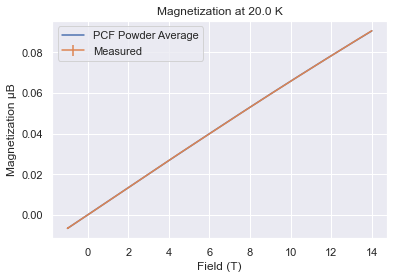

In [143]:
# ## PCF Magnetization
#####################################################################################################################################################################
runs = []
for i in os.listdir(MHDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)

# mass = getMass(runs[0],who = who)

MHdata = {}
# plt.figure()
for i in runs:
    M, H, Err,  mass, T = getData(i,MHDir,who = who, dataType = 'MH')
    M = normalize(M,mass,molweight, 'spin')
    Err = normalize(Err,mass,molweight, 'spin')
    MHdata[T] = [M,H,Err,mass,i]
    # plt.errorbar(H,M, yerr = Err, label = name)

T = '20K'
Temp = getTemp(MHdata[T][-1], who = who)
M, H, Err, mass, filename = MHdata[T]
M = emuToBohr2(M)
H = oeToTesla(H)


# Make LMFIT model and fit
# Create stevens coefficients dictionary from fitted parameters
#####################################################################################################################################################################
magModel = Model(magFit, independent_vars = ['HTes', 'Pr'])
params = magModel.make_params()

# Bounded
params['a'].set(value = 1/3, min = .0001, max = 1)
params['b'].set(value = 1/3, min = .0001, max = 1)
params['c'].set(value = 1/3, min = .0001, max = 1)

## Unbounded
# params['a'].set(value = 1/3)
# params['b'].set(value = 1/3)
# params['c'].set(value = 1/3)

# Fit model to data
magFitted = magModel.fit(M,params,Pr = Pr, HTes = H, LS_on = LS_on, ion = ion)
magFitted.params.pretty_print()

plt.figure()
plt.plot(H,magFitted.best_fit, label = 'PCF Powder Average Fitted')
plt.errorbar(H,M, yerr = Err, label = 'Measured')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization \N{GREEK SMALL LETTER MU}B')
plt.title('Magnetization at {} K'.format(Temp))
plt.legend()
plt.show()
#####################################################################################################################################################################

## Susceptibility (M vs T)

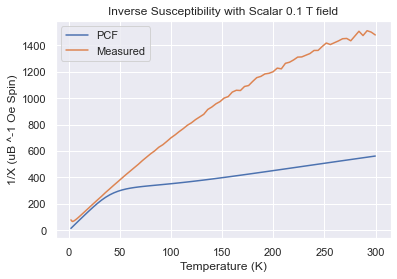

In [144]:
# ## PCF Susceptibility
#####################################################################################################################################################################
runs = []
for i in os.listdir(MTDir):
    if i.endswith('.DAT') or i.endswith('.dat'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)

MTdata = {}
# plt.figure()
for i in runs:
    M,H,T,Err,samplemass,measType = getData(i,MTDir, who = who, dataType = 'MT')
    M = normalize(M,mass,molweight, 'spin')
    Err = normalize(Err,mass,molweight, 'spin')    
    MTdata[measType] = [M,H,T,Err,samplemass]
    # plt.errorbar(H,M, yerr = Err, label = name)

M,H,T,Err,samplemass = MTdata['ZFC']

MBohr = emuToBohr2(M)
HTes = oeToTesla(H)
X = MBohr/HTes
Xi  = 1/X

Ha = .1
XPowder = []
if LS_on:
    for i in T:
        XPowder.append(magFitted.params['a'].value*Pr.magnetization(Temp = i, Field = [Ha, 0, 0])[0] + magFitted.params['b'].value*Pr.magnetization(Temp = i, Field = [0, Ha, 0])[1] + magFitted.params['c'].value*Pr.magnetization(Temp = i, Field = [0, 0, Ha])[2])
else:
    for i in T:
        XPowder.append(magFitted.params['a'].value*Pr.magnetization(Temp = i, Field = [Ha, 0, 0], ion = ion)[0] + magFitted.params['b'].value*Pr.magnetization(Temp = i, Field = [0, Ha, 0], ion = ion)[1] + magFitted.params['c'].value*Pr.magnetization(Temp = i, Field = [0, 0, Ha], ion = ion)[2])
    
XPowder = -np.array(XPowder)/Ha
XiPowder = 1/XPowder

plt.plot(T, XiPowder,label = 'PCF Powder Average Fitted')
plt.plot(T, Xi, label = 'Measured')
plt.xlabel('Temperature (K)')
plt.ylabel('1/X (uB ^-1 Oe Spin)')
plt.title('Inverse Susceptibility with Scalar {} T field'.format(.1))
plt.legend()
# plt.show()
#####################################################################################################################################################################

## PCF Neutron Spectrum
Define: an energy array that will be used to calculate lineshape; neutron incident energy, Ei (mev); temperature (K); instrument resolution (meV).

Instrument resolution is typically ~3% - 5% of the Ei.

Lineshape fitting would be ideal for determining the CF Hamiltonian; however, nuances arise. If not all magnetic modes are seen at a single Ei then certain scaling has to be taken into account to adjust the intensities of the signal. For this reason we decided to go down the route of fitting to energy levels.

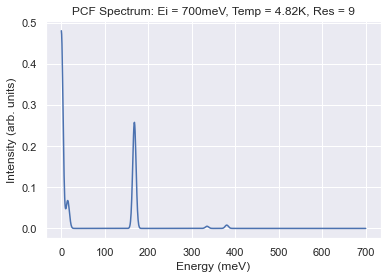

In [145]:
# ## PCF Neutron Spectrum
#####################################################################################################################################################################
Ei = 700
Temp = 4.82
res = 9
energy = np.linspace(.01,Ei,1000)

CalculatedSpectrum = Pr.neutronSpectrum(energy, Temp=Temp, Ei=Ei, ResFunc = lambda x: res )
# ResFunc = lambda x: 9 if (energy < 200) else 21
plt.figure()
plt.plot(energy,CalculatedSpectrum)
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Energy (meV)')
plt.title('PCF Spectrum: Ei = {}meV, Temp = {}K, Res = {}'.format(Ei,Temp,res))
plt.show()
#####################################################################################################################################################################

## Print Hamiltonian in LaTex Format

## Convert our fitted Stevens' to Wybourne and print

In [146]:
print()
Pr.printLaTexEigenvectors()
print()

wyb = cef.StevensToWybourne('Ce3+',stev, LS=True)
print("Fitted coefficients in Wybourne's")
print(wyb)


\begin{table*}
\begin{landscape}
\centering
\caption{Eigenvectors and Eigenvalues... $|L,S\rangle$}
\begin{ruledtabular}
\begin{tabular}{c|cccccccccccccc}
E (meV) &$|-3,-\frac{1}{2}\rangle$ & $|-3,\frac{1}{2}\rangle$ & $|-2,-\frac{1}{2}\rangle$ & $|-2,\frac{1}{2}\rangle$ & $|-1,-\frac{1}{2}\rangle$ & $|-1,\frac{1}{2}\rangle$ & $|0,-\frac{1}{2}\rangle$ & $|0,\frac{1}{2}\rangle$ & $|1,-\frac{1}{2}\rangle$ & $|1,\frac{1}{2}\rangle$ & $|2,-\frac{1}{2}\rangle$ & $|2,\frac{1}{2}\rangle$ & $|3,-\frac{1}{2}\rangle$ & $|3,\frac{1}{2}\rangle$ \tabularnewline
 \hline 
0.000 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.706 & 0.706 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.055 \tabularnewline
0.000 & 0.055 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.706 & 0.706 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \tabularnewline
14.680 & 0.0 & 0.0 & 0.0 & -0.3 & 0.277 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.302 & 0.862 & 0.0 \tabularnewline
14.680 & 0.0 & -0.862 & 0.302 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.277 & 0.3 & 0.0 & 0.0 